# A Real-Time Siren Detector to improve Safety of Guide in Traffic Environment

### Steps:
1. **MDF (Module Difference Function) calculation**    
A time domain technique that aims to classify each portion of the audio signal as pitched or unpitched.
    * MDF Calculation
    * Peak Searching: estimate of the pitch frequency

2. **Pitch Analysis**
If pitch matches the pattern of an emergency signal, then indicate the presence of an emergency signal.

Positive: 13, 15, 18
Doubt: 14, 16
Bad: 11, 

In [1]:
import os
import glob
import time

import numpy as np
#IPython.display for audio output
import IPython.display as ipd
# Librosa for audio
import librosa
import librosa.display

import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
import matplotlib.gridspec as gridspec
%matplotlib inline

In [112]:
file = 'data/emergency/18.wav'
y, sr = librosa.load(file, sr=8000)
ipd.Audio(file)

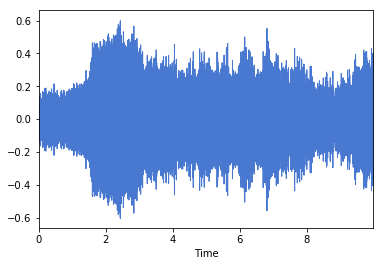

In [113]:
librosa.display.waveplot(y=y, sr=sr)

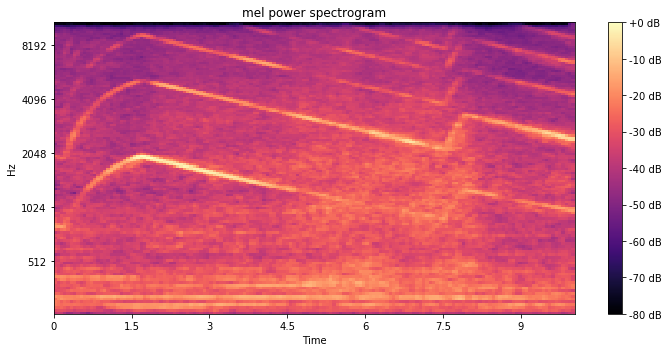

In [114]:
plt.figure(figsize=(10,5))
# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [115]:
def mdf(y,sr,l,m=200,L=100):
    mdf = 0.0
    for n in range(m-L+1,m):
        mdf += abs(y[n] - y[n-l])
    return mdf

In [116]:
def amdf(y,sr,tau,N):
    mdf = 0.0
    for n in range(N-1-tau):
        mdf += abs(y[n] - y[n+tau])
    mdf /= (N-1-tau)
    return mdf

In [117]:
mdf_list = []
N = len(y[:513]) 
for i in range(0,512):
    mdf_list.append(mdf(y=y,sr=sr,l=i,m=N,L=512))

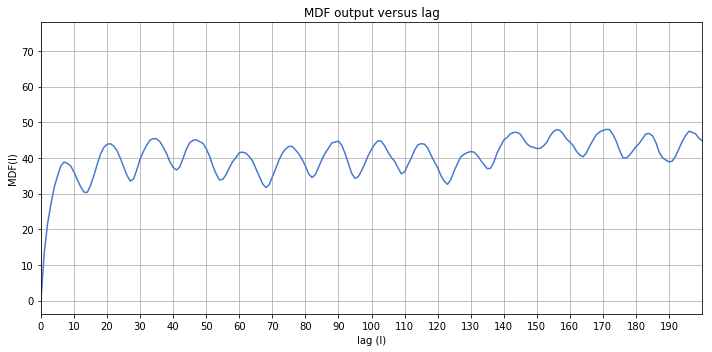

In [118]:
plt.figure(figsize=(10,5))
plt.plot(mdf_list)
plt.title('MDF output versus lag')
plt.xlim([0,200])
plt.xlabel('lag (l)')
plt.ylabel('MDF(l)')
plt.grid('on')
plt.xticks(np.arange(0, 200, 10))
plt.tight_layout()

In [120]:
amdf_list = []
N = len(y[:513])
#print(N)
start = time.time()
for i in range(512):
     amdf_list.append(amdf(y=y,sr=sr,tau=i,N=N))
end = time.time()
print("Execution time for AMDF is {} secs".format(round((end-start),4)))

Execution time for AMDF is 0.096 secs


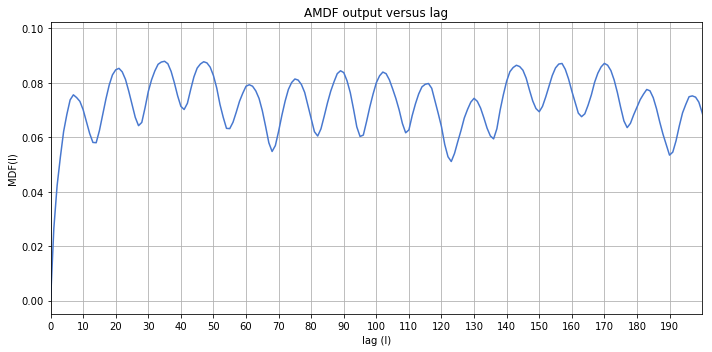

In [121]:
plt.figure(figsize=(10,5))
plt.plot(amdf_list)
plt.title('AMDF output versus lag')
#plt.ylim([0.05,0.1])
plt.xlabel('lag (l)')
plt.xlim([0,200])
plt.ylabel('MDF(l)')
plt.grid('on')
plt.xticks(np.arange(0, 200, 10.0))
plt.tight_layout()

In [122]:
def camdf(y,sr,tau,N):
    D = 0.0
    for n in range(N):
        D += abs(y[(n+tau)%N] - y[n])
    return D

In [123]:
camdf_list = []
N = len(y[:513])
start = time.time()
for i in range(512):
     camdf_list.append(camdf(y=y,sr=sr,tau=i,N=N))
end = time.time()
print("Execution time for CAMDF is {} secs".format(round((end-start),4)))

Execution time for CAMDF is 0.1862 secs


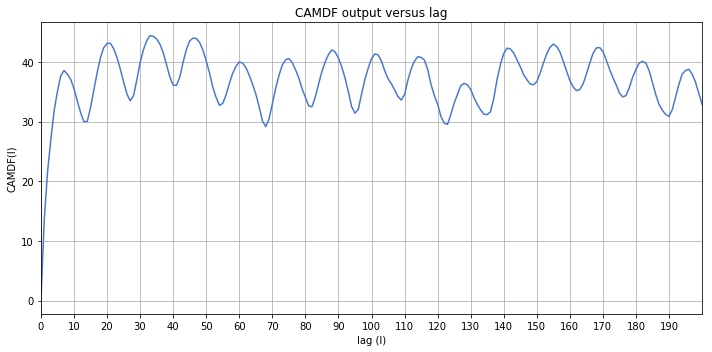

In [124]:
plt.figure(figsize=(10,5))
plt.plot(camdf_list)
plt.title('CAMDF output versus lag')
plt.xlabel('lag (l)')
plt.xlim([0,200])
plt.ylabel('CAMDF(l)')
plt.grid('on')
plt.xticks(np.arange(0, 200, 10.0))
plt.tight_layout()

**From AMDF**

In [125]:
interval = amdf_list[4:100]
#print(interval)
min_D = min(interval)
pitch_detected = round(sr/(interval.index(min_D)+4),2)
print("Detected Pitch: {} Hz".format(pitch_detected))

Detected Pitch: 117.65 Hz


**From CAMDF**

In [126]:
interval = camdf_list[4:100]
min_D = min(interval)
pitch_detected = round(sr/(interval.index(min_D)+4),2)
print("Detected Pitch: {} Hz".format(pitch_detected))

Detected Pitch: 117.65 Hz


### Probability of the presence of a siren

In [127]:
N = len(y[:513])
pitch_list = []
for i in range(30):
    camdf_list = []
    y_clip = y[256*i:256*i+512+1]
    for i in range(512):
        camdf_list.append(camdf(y=y_clip,sr=sr,tau=i,N=N))
    interval = camdf_list[4:100]
    min_D = min(interval)
    pitch_detected = round(sr/(interval.index(min_D)+4),2)
    pitch_list.append(pitch_detected)

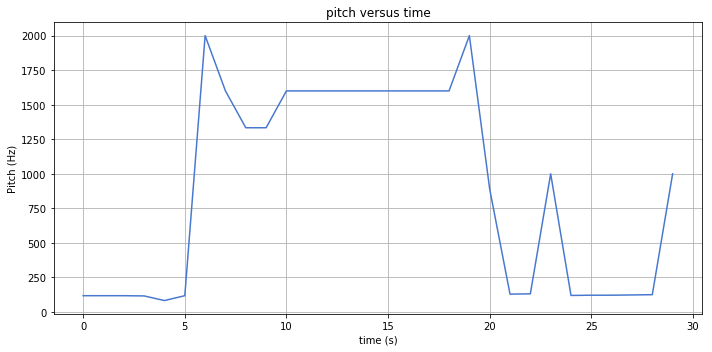

In [128]:
plt.figure(figsize=(10,5))
plt.plot(pitch_list)
plt.title('pitch versus time')
plt.xlabel('time (s)')
#plt.xlim([0,19])
plt.ylabel('Pitch (Hz)')
#plt.xticks(np.arange(0, 19, 1.0))
plt.grid('on')
plt.tight_layout()